<a href="https://colab.research.google.com/github/BonaldSo/project_transformer/blob/main/MyTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

class MultiHeadAttention(nn.Module):
    def __init__(self, d_embedding, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_embedding % n_heads == 0

        self.d_embedding = d_embedding
        self.n_heads = n_heads
        self.d_k = d_embedding // n_heads

        self.W_q = nn.Linear(d_embedding, d_embedding)
        self.W_k = nn.Linear(d_embedding, d_embedding)
        self.W_v = nn.Linear(d_embedding, d_embedding)
        self.W_o = nn.Linear(d_embedding, d_embedding)

    def compute_attention_probs(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output


    def make_heads(self, x):
        batch_size, seq_length, d_embedding = x.size()
        y=x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        return x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

    def join_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_embedding)

    def forward(self, Q, K, V, mask=None):
        Q = self.make_heads(self.W_q(Q))
        K = self.make_heads(self.W_k(K))
        V = self.make_heads(self.W_v(V))
        output = self.compute_attention_probs(Q, K, V, mask)
        output = self.join_heads(output)
        output = self.W_o(output)
        return output





In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_embedding, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_embedding, d_ff)
        self.fc2 = nn.Linear(d_ff, d_embedding)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Returns: The output of encoder on a given input batch x
        """
        aout = self.self_attention(x, x, x, mask)
        aout = self.dropout(aout)
        x = self.norm1(x + aout)
        fout = self.feed_forward(x)
        fout = self.dropout(fout)
        x = self.norm2(x + fout)
        return x



In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()
        """
        Args:
           self_attention: decoder's multi-head attention
           cross_attention: The multi-head attention layer between the encoder and the decoder
           feed_forward: feed-forward layer
           mask: mask to be given for multi head attention
           norm1: First Normalization layer
           norm2: Second Normalization layer
           norm3: Third Normalization layer
           dropout: Final dropout layer
        """
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.cross_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.norm3 = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        """
        Returns: The output of decoder on a given input batch x
        """
        selfout = self.self_attention(x, x, x, tgt_mask)
        selfout = self.dropout(selfout)
        x = self.norm1(x + selfout)
        crossout = self.cross_attention(x, enc_output, enc_output, src_mask)
        crossout = self.dropout(crossout)
        x = self.norm2(x + crossout)
        fout = self.feed_forward(x)
        fout = self.dropout(fout)
        x = self.norm3(x + fout)
        return x


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_embedding, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_embedding)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embedding, 2).float() * -(math.log(10000.0) / d_embedding))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_embedding)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_embedding)
        self.positional_encoding = PositionalEncoding(d_embedding, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_embedding, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    # Masking the input; the outputs returned by this function should be passed to encoder and decoder layers
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        """
        Returns: The output of transformer on a given input batch x
        """
        srcemb = self.positional_encoding(self.encoder_embedding(src))
        tgtemb = self.positional_encoding(self.decoder_embedding(tgt))
        srcemb = self.dropout(srcemb)
        tgtemb = self.dropout(tgtemb)
        encout = srcemb
        for l in self.encoder_layers:
            encout = l(encout, src_mask)
        decout = tgtemb
        for l in self.decoder_layers:
            decout = l(decout, encout, src_mask, tgt_mask)
        output = self.fc(decout)
        return output



In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_embedding = 512
n_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()
losses = []

for epoch in range(25):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    output = output.transpose(1, 2)
    loss = criterion(output, tgt_data[:, 1:])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


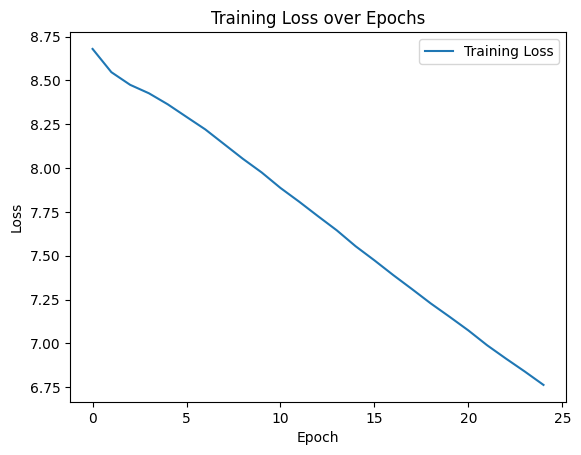

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()